In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib import style

YEARS = list(range(2003, 2019))

### 载入数据

In [3]:
# Load the numpy array with shape (2643, 17, 10)
# (term_num, time_steps, feature_num)
# features: 'df', 'tf', 'author_num', 'ref_num', 'fund_num', 'kw_num', 'kp_num', 'cat_num'

gene_arr = pickle.load(open('output/gene_editing/es_with_decay.array', mode='rb'))
trans_arr = pickle.load(open('output/transplant/es_with_decay.array', mode='rb'))

gene_terms = pickle.load(open('output/gene_editing/ordered_list.list', mode='rb'))
trans_terms = pickle.load(open('output/transplant/ordered_list.list', mode='rb'))

print('Shape of the gene_editing data:', gene_arr.shape)
print('Shape of the transplant data:', trans_arr.shape)

Shape of the gene_editing data: (2643, 17, 10)
Shape of the transplant data: (5141, 17, 10)


### 2019年的数据为wos错误导出的，排除

In [4]:
gene_arr = gene_arr[:, :-1, :]
trans_arr = trans_arr[:, :-1, :]

print('Shape of the gene_editing data:', gene_arr.shape)
print('Shape of the transplant data:', trans_arr.shape)

Shape of the gene_editing data: (2643, 16, 10)
Shape of the transplant data: (5141, 16, 10)


### 整体Emerging Score在16年间的分布情况

可以看到随着时间增长，Emerging Score整体是在上升的

并且它的分布很不均衡，离群点很多

In [5]:
gene_es = gene_arr[:, :, -2]
trans_es = trans_arr[:, :, -2]

def es_annual_boxplot(es, title):
    fig, ax = plt.subplots(1, 1, figsize=(8,4))
    ax.boxplot(es)
    ax.set_xticklabels(YEARS)
    ax.set_xlabel('Year')
    ax.set_ylabel('Emerging Score')
    ax.set_title(title)
    plt.tight_layout()
    plt.show()
    
def es_annual_errorplot(es, title):
    median = np.median(es, axis=0)
    upper_75 = np.percentile(es, [75], axis=0).reshape(-1) - median
    lower_25 = median - np.percentile(es, [25], axis=0).reshape(-1)
    fig, ax = plt.subplots(1, 1, figsize=(10,4))
    ax.errorbar(range(len(median)), median, yerr=[lower_25, upper_75],
                fmt='o', capsize=3, elinewidth=0.5, ecolor='black', markersize=8)
    ax.set_xticks(np.arange(len(YEARS)))
    ax.set_xticklabels(YEARS)
    ax.set_xlabel('Year')
    ax.set_ylabel('Emerging Score')
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

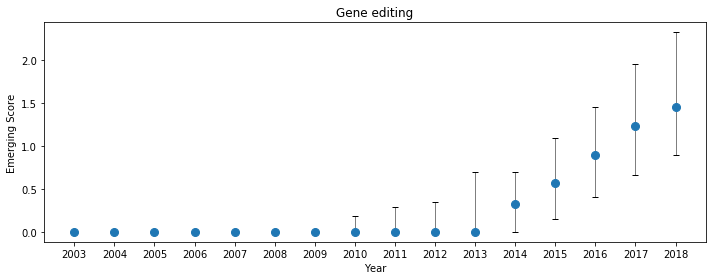

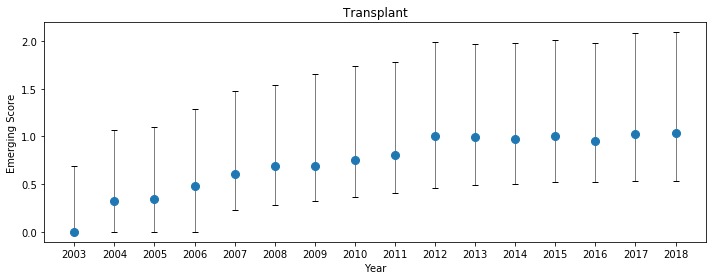

In [6]:
# es_annual_boxplot(gene_es, 'Gene editing')
# es_annual_boxplot(trans_es, 'Transplant')

es_annual_errorplot(gene_es, 'Gene editing')
es_annual_errorplot(trans_es, 'Transplant')

### 随机抽取术语观察其在16年间的变化

波动较大，术语之间、同一个术语前后的规律都不太一样

利用线性回归线可以大致估计其趋势

In [43]:
def random_show_terms():
    num = 3
    gene_rids = list(np.random.choice(range(len(gene_arr)), size=num, replace=False))
    trans_rids = list(np.random.choice(range(len(trans_arr)), size=num, replace=False))

    rids = gene_rids + trans_rids

    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(18,12))
    axes = [ax1, ax2, ax3, ax4, ax5, ax6]

    i = 0
    for i in range(len(axes)):
        x = range(len(YEARS))
        if i < len(axes) / 2:
            axes[i].plot(x, gene_es[rids[i]])
            a, b = np.polyfit(range(len(YEARS)), gene_es[rids[i]], 1)
            axes[i].plot(x, a*x+b, label='a={:.2f}'.format(a))
            axes[i].set_title('Gene editing:' + str(gene_terms[rids[i]]))
        else:
            axes[i].plot(x, trans_es[rids[i]])
            a, b = np.polyfit(range(len(YEARS)), trans_es[rids[i]], 1)
            axes[i].plot(x, a*x+b, label='a={:.2f}'.format(a))
            axes[i].set_title('Transplant:' + str(trans_terms[rids[i]]))
        axes[i].set_xticks(np.arange(len(YEARS)))
        axes[i].set_xticklabels(YEARS)
        axes[i].set_xlabel('Year')
        axes[i].set_ylabel('Emerging Score')
        axes[i].legend()

    plt.tight_layout()
    plt.show()

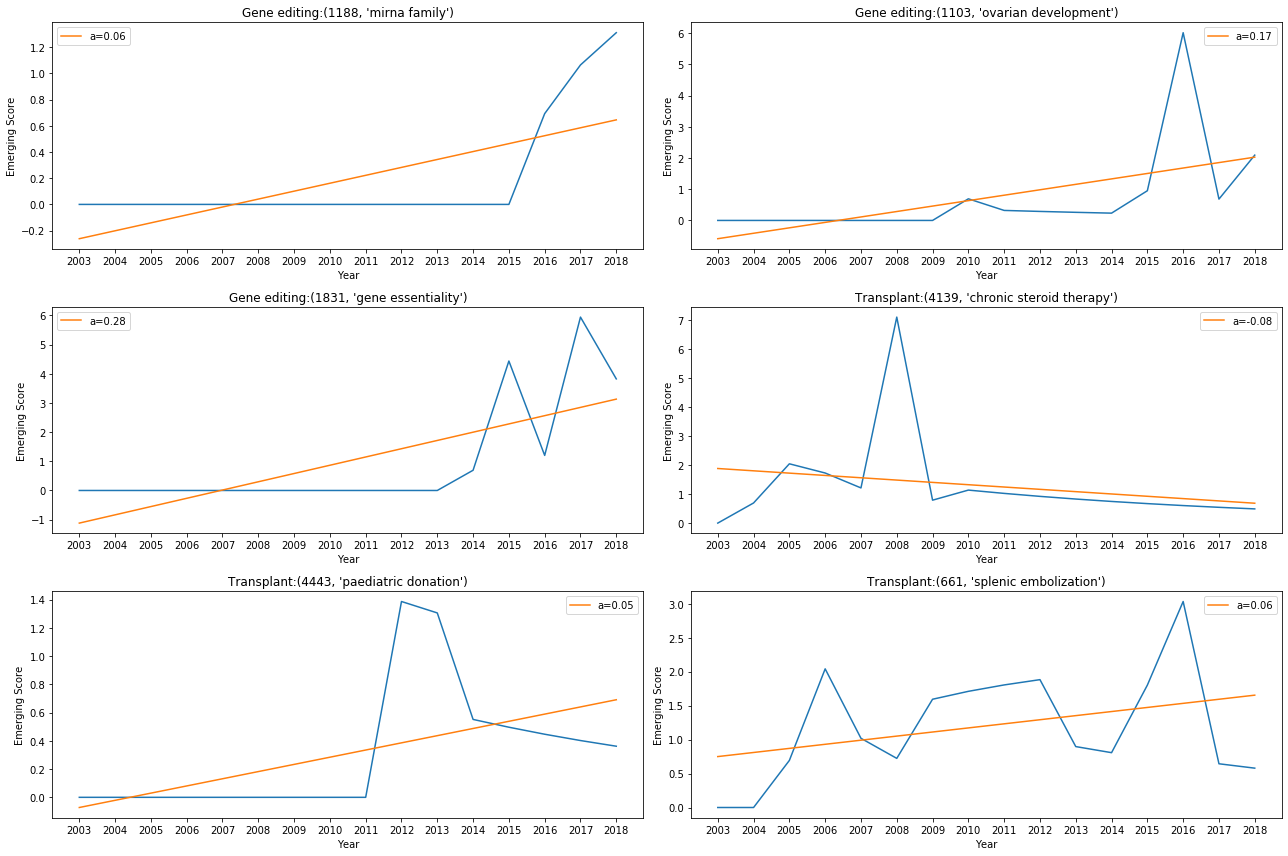

In [44]:
random_show_terms()

### 每个术语Emerging Score总量

如果要按总量来分的话，按照这样的分法可能比较合适（从高到低）：
- 离群点（大于Q3+1.5IQR）
- 较高（Q3+1.5IQR 到 Q3之间）
- 中间（Q3 到 Q1之间）
- 较低（Q1 到 最小值之间）

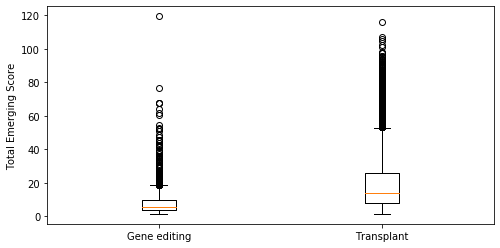

In [27]:
gene_total_es = np.sum(gene_es, axis=1)
trans_total_es = np.sum(trans_es, axis=1)

def compare_total_es(es1, es2):
    fig, ax = plt.subplots(1, 1, figsize=(8,4))
    ax.boxplot((es1, es2))
    ax.set_xticklabels(['Gene editing', 'Transplant'])
    ax.set_ylabel('Total Emerging Score')
    plt.show()

compare_total_es(gene_total_es, trans_total_es)